In [ ]:
# Add heat amount that was dedicated to space or water heating
# Average that over the year and seasons, and then over all houses

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings
import re
import os
from os import listdir
from os.path import isfile, join
warnings.filterwarnings("ignore")
import datetime


In [105]:
# Read the files and sort the data in dataframes 
raw_path = '/Users/sofiaperelli-rocco/Desktop/UK_EoH_2020-2022/'
properties_path = raw_path + '9050_csv_united_cleansed_data/'
csv_file_path_ID = properties_path + 'Property_ID=EOH1664.csv' # Upload 2min data of the selected house - EOH0003, EOH0018 (boiler), EOH0021, EOH0026, EOH0031, EOH0184, EOH1664 or EOH3107 (no output from CD code?)
property_df = pd.read_csv(csv_file_path_ID) 
all_performance_df = pd.read_csv(raw_path + "heat_pump_performance_summary_v1-0.csv") 
csv_file_path_info = "BEIS Electrification of Heat Project - Property, Design and Installation Information.csv"
properties_info_df = pd.read_csv(raw_path + csv_file_path_info)


In [106]:
# Identify the names of columns of data that are taken in a cumulative way
columns_to_diff = ['Circulation_Pump_Energy_Consumed', 'Heat_Pump_Energy_Output','Boiler_Energy_Output',
                   'Immersion_Heater_Energy_Consumed', 'Whole_System_Energy_Consumed', 'Back-up_Heater_Energy_Consumed', 'HP_Consumption']

# Identigy the names of clumns that we want the mean of, to then group them at the same time of the day 
columns_to_mean = ['delta_Circulation_Pump_Energy_Consumed', 'External_Air_Temperature', 'delta_Heat_Pump_Energy_Output',
                   'Heat_Pump_Heating_Flow_Temperature', 'Heat_Pump_Return_Temperature', 'Hot_Water_Flow_Temperature',
                   'delta_Immersion_Heater_Energy_Consumed', 'Internal_Air_Temperature', 'delta_Whole_System_Energy_Consumed',
                  'delta_Boiler_Energy_Output', 'delta_Back-up_Heater_Energy_Consumed', 'delta_HP_Consumption'] 

# Identify the names of columns that we need to subtract to obtain the heat pump only power
keys_to_subtract_for_HP_energy= ['Back-up_Heater_Energy_Consumed', 'Immersion_Heater_Energy_Consumed', 'Circulation_Pump_Energy_Consumed']

# Identify columns needed for COP and SPFHn calculations
columns_SPFn = ['Circulation_Pump_Energy_Consumed', 'Immersion_Heater_Energy_Consumed', 'Back-up_Heater_Energy_Consumed', 'HP_Consumption', 'Heat_Pump_Energy_Output']
columns_SPFn_inst = ['delta_Circulation_Pump_Energy_Consumed', 'delta_Immersion_Heater_Energy_Consumed', 'delta_Back-up_Heater_Energy_Consumed', 'delta_HP_Consumption', 'delta_Heat_Pump_Energy_Output']


In [107]:
def fill_cumulative_data(df):
    col_fill = [col for col in columns_to_diff if col != 'HP_Consumption']
    df_copy = df.copy()

    for col in col_fill:
        if col not in df_copy:
            df_copy[col] = np.nan

    for col in col_fill:
        forward_filled = df_copy[col].ffill()
        backward_filled = df_copy[col].bfill()
        match_mask = (forward_filled == backward_filled)
        df_copy[col] = df_copy[col].mask(match_mask, forward_filled)

    for key in df_copy.keys():
        if key not in df.keys():
            df_copy.drop(key, axis=1, inplace=True)
    return(df_copy)

In [108]:
def get_SPFn(df):
    window_df_copy = df.copy()
    
    for column in columns_SPFn:
        if column not in window_df_copy.columns:
            window_df_copy[column] = 0

    valid_rows = window_df_copy.loc[(~window_df_copy['Heat_Pump_Energy_Output'].isnull()) &
                                    (~window_df_copy['HP_Consumption'].isnull()) &
                                    (~window_df_copy['Immersion_Heater_Energy_Consumed'].isnull()) &
                                    (~window_df_copy['Back-up_Heater_Energy_Consumed'].isnull()) &
                                    (~window_df_copy['Circulation_Pump_Energy_Consumed'].isnull())]

    if len(valid_rows) == 0:
        return float('nan'), float('nan'), float('nan')

    first_valid_row = valid_rows.iloc[0]
    last_valid_row = valid_rows.iloc[-1]

    initial_Heat_Pump_Energy_Output = first_valid_row['Heat_Pump_Energy_Output']
    final_Heat_Pump_Energy_Output = last_valid_row['Heat_Pump_Energy_Output']
    initial_HP_Consumption = first_valid_row['HP_Consumption']
    final_HP_Consumption = last_valid_row['HP_Consumption']
    initial_Immersion_Heater_Energy_Consumed = first_valid_row['Immersion_Heater_Energy_Consumed']
    final_Immersion_Heater_Energy_Consumed = last_valid_row['Immersion_Heater_Energy_Consumed']
    initial_Circulation_Pump_Energy_Consumed = first_valid_row['Circulation_Pump_Energy_Consumed']
    final_Circulation_Pump_Energy_Consumed = last_valid_row['Circulation_Pump_Energy_Consumed']
    initial_Back_up_Heater_Energy_Consumed = first_valid_row['Back-up_Heater_Energy_Consumed']
    final_Back_up_Heater_Energy_Consumed = last_valid_row['Back-up_Heater_Energy_Consumed']

    avg_SPFH2 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                final_HP_Consumption - initial_HP_Consumption) if (
                final_HP_Consumption - initial_HP_Consumption) != 0 else float('nan')
    avg_SPFH3 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed)) if (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed)) != 0 else float('nan')
    avg_SPFH4 = (final_Heat_Pump_Energy_Output - initial_Heat_Pump_Energy_Output) / (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed) +
                (final_Circulation_Pump_Energy_Consumed - initial_Circulation_Pump_Energy_Consumed)) if (
                (final_HP_Consumption - initial_HP_Consumption) +
                (final_Immersion_Heater_Energy_Consumed - initial_Immersion_Heater_Energy_Consumed) +
                (final_Back_up_Heater_Energy_Consumed - initial_Back_up_Heater_Energy_Consumed) +
                (final_Circulation_Pump_Energy_Consumed - initial_Circulation_Pump_Energy_Consumed)) != 0 else float('nan')

    return avg_SPFH2, avg_SPFH3, avg_SPFH4


In [109]:
def get_period_consumption(window_df):
    result = {}
    
    for column in columns_to_diff:
        if column in window_df.columns:
            column_data = window_df[column].dropna()
            if len(column_data) > 0:
                result['Property_ID'] = property_ID
                result[column] = column_data.iloc[-1] - column_data.iloc[0]
            else:
                result[column] = np.nan
    
    return result


In [110]:
def get_inst_SPFHn(df):
    df_copy = df.copy()
    
    for column in columns_SPFn_inst: 
        if column not in df_copy.columns:
            df_copy[column] = 0
            
    df['SPFH2_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0),
                                         df_copy['delta_Heat_Pump_Energy_Output'] / df_copy['delta_HP_Consumption'], np.nan) 
    
    df['SPFH3_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0), 
                                         df_copy['delta_Heat_Pump_Energy_Output'] / (df_copy['delta_HP_Consumption'] + df_copy['delta_Immersion_Heater_Energy_Consumed'] + df_copy['delta_Back-up_Heater_Energy_Consumed']), np.nan) 

    df['SPFH4_instantaneous'] = np.where( (df_copy['delta_HP_Consumption'] > 0), 
                                         df_copy['delta_Heat_Pump_Energy_Output'] / (df_copy['delta_HP_Consumption'] + df_copy['delta_Immersion_Heater_Energy_Consumed'] + df_copy['delta_Back-up_Heater_Energy_Consumed'] + df_copy['delta_Circulation_Pump_Energy_Consumed']), np.nan)      
    
    return df
    

In [111]:
def get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4):
    mean_df['Property_ID'] = property_ID
    mean_df['House_SAP'] = merged_df['House_SAP'].iloc[0]
    mean_df['MCS_SHLoad'] = merged_df['MCS_SHLoad'].iloc[0] #NEW
    mean_df['MCS_Hloss'] = merged_df['MCS_Hloss'].iloc[0]
    mean_df['Total_Floor_Area'] = merged_df['Total_Floor_Area'].iloc[0]
    mean_df['MCS_tot_Hloss_kW'] = ( round((mean_df['MCS_Hloss']*mean_df['Total_Floor_Area'])/1000 ,5)) # NEW
    mean_df['HP_Installed'] = merged_df['HP_Installed'].iloc[0]
    mean_df['SPFH2'] = avg_SPFH2
    mean_df['SPFH3'] = avg_SPFH3
    mean_df['SPFH4'] = avg_SPFH4
    
    return(mean_df)

In [112]:
def extract_SPFn(df):
    SPFH2_all = []
    SPFH3_all = []
    SPFH4_all = []
    for i in df['Property_ID'].unique():
        filter_df = df[df['Property_ID'] == i]
        SPFH2 = filter_df['SPFH2'].iloc[0]
        SPFH3 = filter_df['SPFH3'].iloc[0]
        SPFH4 = filter_df['SPFH4'].iloc[0]
        SPFH2_all.append(SPFH2)
        SPFH3_all.append(SPFH3)
        SPFH4_all.append(SPFH4)
    SPFH2_mean = np.array(SPFH2_all).mean()
    SPFH3_mean = np.array(SPFH3_all).mean()
    SPFH4_mean = np.array(SPFH4_all).mean()
    
    return SPFH2_mean, SPFH3_mean, SPFH4_mean

In [113]:
def get_6pm_CD_temp(cold_window, no6pm_count):
    cold_window['Timestamp']=pd.to_datetime(cold_window['Timestamp'],format='%Y-%m-%d %H:%M:%S' )
    filtered_rows = cold_window[cold_window['Timestamp'].dt.strftime('%H:%M') == '18:00']
    if not filtered_rows.empty:
        temperature_value = filtered_rows['Internal_Air_Temperature'].iloc[0]
        cold_window['CD_six_pm_temp'] = temperature_value
    else:
        cold_window['CD_six_pm_temp'] = None # Handle the case when no rows match the condition - count!
        no6pm_count +=1
    return(cold_window, no6pm_count)

# 1. Convert clean and select the relevant data

In [114]:
# Find the name of the house you are analysing, open its raw data file and extract its information from performance and survey files 
property_df['Property_ID'] = csv_file_path_ID.split("=",1)[1][:7]
property_ID = property_df['Property_ID'][1]
property_performance = all_performance_df[all_performance_df['Property_ID'] == property_ID]
merged_df = properties_info_df.merge(property_performance, on='Property_ID', how='inner')
HP_size = merged_df['HP_Size_kW'][0] 
#property_performance


In [115]:
# Check if it works on house EOH0003, at day 2022/05/27 from 22.24 to 23:58 [around row index 285500]
property_df = fill_cumulative_data(property_df)


In [116]:
# Convert to datetime and calculate the difference between each data point time in seconds, in the file with row property data
property_df['Timestamp'] = pd.to_datetime(property_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
property_df['Date'] = property_df['Timestamp'].dt.date
property_df['Time'] = property_df['Timestamp'].dt.time
property_df['time_diff_seconds'] = property_df['Timestamp'].diff().dt.total_seconds()


In [117]:
# Create a new column to mark the actual HP consumption, by subtracting from the whole system consumptions the other columns
property_df['HP_Consumption'] = property_df['Whole_System_Energy_Consumed']
for key in keys_to_subtract_for_HP_energy:
    if key in property_df.keys():
        property_df['HP_Consumption'] -= property_df[key]  
     

In [118]:
# Convert cumulative energy values to avarage power based on the energy and time value of the previous data point
for column in columns_to_diff:
           if column in property_df.keys():
                new_col_name = f"delta_{column}"
                property_df[new_col_name] = (property_df[column].diff() * 3600 /property_df['time_diff_seconds'])
                

In [130]:
# Count rows where both DHW and SH temperature columns are NaN
both_nan_count = ((property_df['Heat_Pump_Heating_Flow_Temperature'].isna()) & (property_df['Hot_Water_Flow_Temperature'].isna())).sum()
# Count rows where neither column is NaN (split)
neither_nan_count = ((property_df['Heat_Pump_Heating_Flow_Temperature'].notna()) & (property_df['Hot_Water_Flow_Temperature'].notna())).sum()
print("Count of rows where both columns are NaN:", both_nan_count, "\nCount of rows where neither column is NaN:", neither_nan_count)
# Property ID 0003, property_df.head(30)

# Create a dataframe that takes away the rows where it is ambiguous wether heat goes to water or to space heating
property_df = property_df[~((property_df['Heat_Pump_Heating_Flow_Temperature'].isna()) & (property_df['Hot_Water_Flow_Temperature'].isna())) & ~((property_df['Heat_Pump_Heating_Flow_Temperature'].notna()) & (property_df['Hot_Water_Flow_Temperature'].notna()))]

# Initialize the new columns with NaN values
property_df['SH_HP_power_output'] = np.nan
property_df['DHW_HP_power_output'] = np.nan

# Assign values based on conditions
property_df.loc[property_df['Heat_Pump_Heating_Flow_Temperature'].notna(), 'SH_HP_power_cons'] = property_df['delta_HP_Consumption']
property_df.loc[property_df['Hot_Water_Flow_Temperature'].notna(), 'DHW_HP_power_cons'] = property_df['delta_HP_Consumption']


KeyError: 'Hot_Water_Flow_Temperature'

In [ ]:
# Now convert to time the start and end times of the clean data window indicated by the govt in the performance file
property_performance['Selected_window_start'] = pd.to_datetime(property_performance['Selected_window_start'], format='%d/%m/%Y').dt.date
property_performance['Selected_window_end'] = pd.to_datetime(property_performance['Selected_window_end'], format='%d/%m/%Y').dt.date
start_date = property_performance['Selected_window_start'].iloc[0]
end_date = property_performance['Selected_window_end'].iloc[0]
window_df = property_df[(property_df['Date'] >= start_date) & (property_df['Date'] <= end_date)]
#window_df.delta_HP_Consumption.hist()

print(start_date, end_date)

In [ ]:
data_year = pd.DataFrame()
data_CD = pd.DataFrame()
data_winter = pd.DataFrame()

consumption_data_year = get_period_consumption(window_df)
data_year = data_year.append(consumption_data_year, ignore_index=True)

''' 
consumption_data_winter = get_period_consumption(winter_df)
data_winter = data_winter.append(consumption_data_winter, ignore_index=True)
consumption_data_CD = get_period_consumption(cold_window)
data_CD = data_CD.append(consumption_data_CD, ignore_index=True)
'''

data_year

<AxesSubplot:>

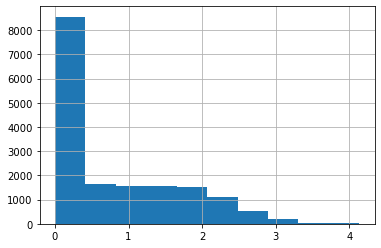

In [120]:
# Calculate the average SPFH2,3,4 over the year
avg_SPFH2, avg_SPFH3, avg_SPFH4 = get_SPFn(window_df) 

# Group all window data in 30 minutes
window_df = window_df.set_index('Timestamp')
window_df = window_df.resample('30T').mean()
window_df = window_df.reset_index()
window_df['Time'] = window_df['Timestamp'].dt.time

# Calculate instantaneous SPFHn
window_df = get_inst_SPFHn(window_df) 

window_df.delta_HP_Consumption.hist()


In [121]:
valid_rows = window_df['DHW_HP_power_cons'].notna()  # Boolean series indicating rows where the value is not NaN
valid_data = window_df.loc[valid_rows]  # Select the rows where the value is not NaN
DHW_energy_year_kWh = (valid_data['SH_HP_power_cons'] / 2).sum()

valid_rows = window_df['SH_HP_power_cons'].notna()  # Boolean series indicating rows where the value is not NaN
valid_data = window_df.loc[valid_rows]  # Select the rows where the value is not NaN
SH_energy_year_kWh = (valid_data['SH_HP_power_cons'] / 2).sum()

print('DHW_energy_year_kWh',DHW_energy_year_kWh, 'kWh')
print('SH_energy_year_kWh', SH_energy_year_kWh, 'kWh')
print('Tot heat output bw the two:', DHW_energy_year_kWh + SH_energy_year_kWh)
print(window_df['HP_Consumption'].iloc[-1]-window_df['HP_Consumption'].iloc[0])

# EOH0003 DHW_energy_year 22.59 kWh, SH 79,861.59 kWh


DHW_energy_year_kWh 488.9048974359096 kWh
SH_energy_year_kWh 5609.121670347738 kWh
Tot heat output bw the two: 6098.026567783647
6712.179704761904


# 2. Plot the typical daily profile of the year and season

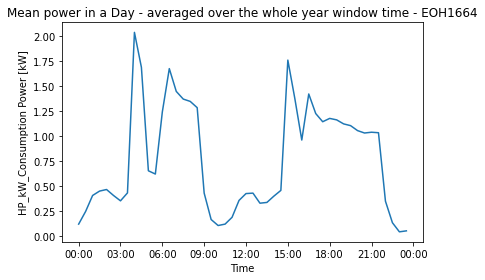

Max avarage power 2.0 kW compared to Hybrid of size 4.0 kW.


In [122]:
# Now we want to find the mean HP power (and temperature etc) of the whole year, at the selected time of the day
cols_mean = [column for column in columns_to_mean + ['SPFH2_instantaneous', 'SPFH3_instantaneous', 'SPFH4_instantaneous', 'SH_HP_power_cons', 'DHW_HP_power_cons'] if column in window_df.keys()]
mean_df = window_df.groupby('Time')[cols_mean].mean().reset_index()
mean_df['Time'] = pd.to_datetime(mean_df['Time'], format='%H:%M:%S')
mean_df=get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)

plt.plot(mean_df['Time'], mean_df['delta_HP_Consumption'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('HP_kW_Consumption Power [kW]')
plt.title('Mean power in a Day - averaged over the whole year window time - {}'.format(property_ID))
plt.tight_layout()
plt.show()
print('Max avarage power',round(mean_df['delta_HP_Consumption'].max(),1), 'kW compared to', mean_df['HP_Installed'].iloc[0],'of size', HP_size, 'kW.')


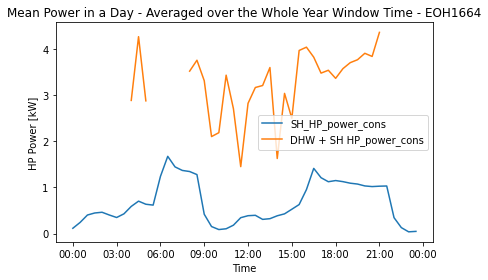

Max average power: 3.6 kW compared to Hybrid of size 4.0 kW.


In [123]:
plt.plot(mean_df['Time'], mean_df['SH_HP_power_cons'], label='SH_HP_power_cons')
plt.plot(mean_df['Time'], mean_df['DHW_HP_power_cons']+mean_df['SH_HP_power_cons'], label='DHW + SH HP_power_cons')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('HP Power [kW]')
plt.title('Mean Power in a Day - Averaged over the Whole Year Window Time - {}'.format(property_ID))
plt.tight_layout()
plt.legend()
plt.show()

max_avg_power = round(mean_df[['SH_HP_power_cons', 'DHW_HP_power_cons']].max().max(), 1)
hp_installed = mean_df['HP_Installed'].iloc[0]
print('Max average power:', max_avg_power, 'kW compared to', hp_installed, 'of size', HP_size, 'kW.')

In [124]:
# Group the window dataframe based on date, to allocate data with the correspondnig season 
window_df['Date'] = window_df['Timestamp'].dt.date
window_df['Date'] = pd.to_datetime(window_df['Date'], format='%Y-%m-%d')

winter_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([12, 1, 2]))]
spring_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([3, 4, 5]))]
summer_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([6, 7, 8]))]
autumn_df = window_df[(pd.DatetimeIndex(window_df['Date']).month.isin([9, 10, 11]))]
seasons = {'winter': winter_df, 'spring': spring_df, 'summer': summer_df, 'autumn': autumn_df}


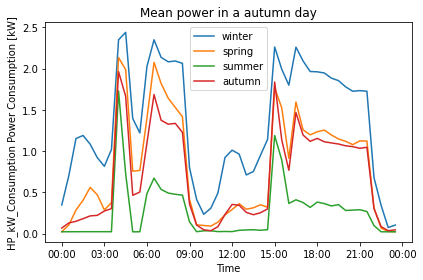

In [125]:
fig, ax = plt.subplots()
for season, df in seasons.items():
    mean_df = df.groupby('Time')[cols_mean].mean().reset_index()
    mean_df['Time'] = pd.to_datetime(mean_df['Time'], format='%H:%M:%S')
    mean_df=get_house_info(mean_df, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)

    ax.plot(mean_df['Time'], mean_df['delta_HP_Consumption'], label=season )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('HP_kW_Consumption Power Consumption [kW]')
    ax.set_title('Mean power in a {} day'.format(season))
plt.tight_layout()
plt.legend()
plt.show()

# Why does autumn of EOH0021 have such high peaks?  

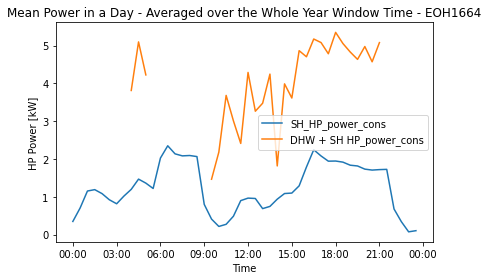

Max average power: 3.6 kW compared to Hybrid of size 4.0 kW.


In [126]:
winter_df_water = winter_df.groupby('Time')[cols_mean].mean().reset_index()
winter_df_water['Time'] = pd.to_datetime(winter_df_water['Time'], format='%H:%M:%S')
#winter_df_water=get_house_info(winter_df_water, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)

plt.plot(winter_df_water['Time'], winter_df_water['SH_HP_power_cons'], label='SH_HP_power_cons')
plt.plot(winter_df_water['Time'], winter_df_water['DHW_HP_power_cons']+winter_df_water['SH_HP_power_cons'], label='DHW + SH HP_power_cons')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('HP Power [kW]')
plt.title('Mean Power in a Day - Averaged over the Whole Year Window Time - {}'.format(property_ID))
plt.tight_layout()
plt.legend()
plt.show()

max_avg_power = round(mean_df[['SH_HP_power_cons', 'DHW_HP_power_cons']].max().max(), 1)
hp_installed = mean_df['HP_Installed'].iloc[0]
print('Max average power:', max_avg_power, 'kW compared to', hp_installed, 'of size', HP_size, 'kW.')

# Meeting with Philipp
- Hot water = summer baseline?
- Negative readings = PVs?
- Find maximum data points to show the peak?

# Coldest day analysis

In [127]:
# Select the coldest day (must convert from dd/mm/YYYY to YYYY-mm-dd) and filter the dataframe
property_performance['Coldest_day_start'] = pd.to_datetime(property_performance['Coldest_day_start'], format='%d/%m/%Y %H:%M')
property_performance['Coldest_day_end'] = property_performance['Coldest_day_start'] + pd.DateOffset(hours=24)
CD_start_date = property_performance['Coldest_day_start'].iloc[0]
CD_end_date = property_performance['Coldest_day_end'].iloc[0]

print(CD_start_date, CD_end_date)

2021-02-11 00:00:00 2021-02-12 00:00:00


In [128]:
# Filter the coldest day dataframe, and reconvert datetimes (useful for figure later)
window_df['Date'] = window_df['Timestamp'].dt.date
cold_window = window_df[(window_df['Date'] >= CD_start_date) & (window_df['Date'] < CD_end_date)]
cold_window['Time'] = pd.to_datetime(cold_window['Time'], format='%H:%M:%S')


In [129]:
cold_window

,Timestamp,Circulation_Pump_Energy_Consumed,External_Air_Temperature,Heat_Pump_Energy_Output,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,Hot_Water_Flow_Temperature,Immersion_Heater_Energy_Consumed,Internal_Air_Temperature,Whole_System_Energy_Consumed,...,delta_HP_Consumption,SH_HP_power_output,DHW_HP_power_output,SH_HP_power_cons,DHW_HP_power_cons,Time,SPFH2_instantaneous,SPFH3_instantaneous,SPFH4_instantaneous,Date


In [28]:
no6pm_count = 0
avg_CD_SPFH2, avg_CD_SPFH3, avg_CD_SPFH4 = get_SPFn(cold_window) 
cold_window=get_house_info(cold_window, property_ID, merged_df, avg_SPFH2, avg_SPFH3, avg_SPFH4)
cold_window['avg_CD_SPFH2'] = avg_CD_SPFH2 
cold_window['avg_CD_SPFH3'] = avg_CD_SPFH3 
cold_window['avg_CD_SPFH4'] = avg_CD_SPFH4 
cold_window['min_Internal_Air_Temperature']= cold_window['Internal_Air_Temperature'].min()
cold_window['max_HP_power_cons'] = cold_window['delta_HP_Consumption'].max()
cold_window['max_whole_system_power_cons'] = cold_window['delta_Whole_System_Energy_Consumed'].max()
cold_window, no6pm_count = get_6pm_CD_temp(cold_window, no6pm_count)

cold_window

,Timestamp,Circulation_Pump_Energy_Consumed,External_Air_Temperature,Heat_Pump_Energy_Output,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,Hot_Water_Flow_Temperature,Immersion_Heater_Energy_Consumed,Internal_Air_Temperature,Whole_System_Energy_Consumed,...,SPFH2,SPFH3,SPFH4,avg_CD_SPFH2,avg_CD_SPFH3,avg_CD_SPFH4,min_Internal_Air_Temperature,max_HP_power_cons,max_whole_system_power_cons,CD_six_pm_temp


In [ ]:
# Plot of the coldest day HP consumption and temperature - should I plot whole system consumption instead, to see stress on grid including all electricity contributions?
fig, ax1 = plt.subplots()

ax1.plot(cold_window['Time'], cold_window['delta_HP_Consumption'], color='tab:red', label='delta_HP_Consumption')
ax1.set_xlabel('Time')
ax1.set_ylabel('delta_HP_Consumption Power [kW]', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
ax2.plot(cold_window['Time'], cold_window['Internal_Air_Temperature'], color='tab:blue', label='Internal_Air_Temperature')
ax2.set_ylabel('Internal_Air_Temperature [°C]', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Power and Temperature in the coldest Day for - {}'.format(property_ID))
plt.tight_layout()
plt.show()


In [ ]:
consumption_data_CD = get_period_consumption(cold_window)
consumption_data_CD['Property_ID'] = property_ID
consumption_data_CD

In [ ]:
max_energy_consumed = cold_window['delta_Whole_System_Energy_Consumed'].max()
time_of_max_WS_power= cold_window.loc[cold_window['delta_Whole_System_Energy_Consumed'].idxmax(), 'Time']
heat_output=cold_window.loc[cold_window['delta_Whole_System_Energy_Consumed'].idxmax(), 'delta_Heat_Pump_Energy_Output']

max_HP_power = cold_window['delta_HP_Consumption'].max()
time_of_max_HP_power= cold_window.loc[cold_window['delta_HP_Consumption'].idxmax(), 'Time']
HP_consump_at_max_WS_power= cold_window.loc[cold_window['delta_Whole_System_Energy_Consumed'].idxmax(), 'delta_HP_Consumption']

print('HP size:', HP_size, 'kW')
print('max whole system power consumed', round(max_energy_consumed,2), 'kW, at which point the HP consumes', round(HP_consump_at_max_WS_power,2), 'kW, occuring at', time_of_max_WS_power, '. The heat output is kW', round(heat_output,2) )
print('Max HP power', round(max_HP_power,2) ,'kW at time', time_of_max_HP_power)


In [ ]:
# Retrive MCS heat loss calculation, HP type etc.
cold_window['MCS_Hloss'] = merged_df['MCS_Hloss'].iloc[0] # NEW
cold_window['Total_Floor_Area'] = merged_df['Total_Floor_Area'].iloc[0] # NEW
cold_window['MCS_tot_Hloss_kW'] = ( round((cold_window['MCS_Hloss']*cold_window['Total_Floor_Area'])/1000 ,3)) # NEW
cold_window['HP_Installed'] = merged_df['HP_Installed'].iloc[0] # NEW

min_indoor_temp = cold_window['Internal_Air_Temperature'].min()
cold_window['min_Internal_Air_Temperature']= cold_window['Internal_Air_Temperature'].min()
cold_window['max_whole_system_power_cons'] = cold_window['delta_Whole_System_Energy_Consumed'].max()
cold_window['max_HP_power_cons'] = cold_window['delta_HP_Consumption'].max()

cold_window